In [1]:
from sklearn.datasets import load_wine
import pandas as pd

X = pd.read_csv('BTC-USD.csv').drop('Date', axis=1)
X.columns = X.columns.str.replace(' ', '_')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2747 non-null   float64
 1   High       2747 non-null   float64
 2   Low        2747 non-null   float64
 3   Close      2747 non-null   float64
 4   Adj_Close  2747 non-null   float64
 5   Volume     2747 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 128.9 KB


In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_stand = scaler.fit_transform(X)
X_stand[0]

array([-0.68641221, -0.68706763, -0.68718818, -0.68753645, -0.68753645,
       -0.74335977])

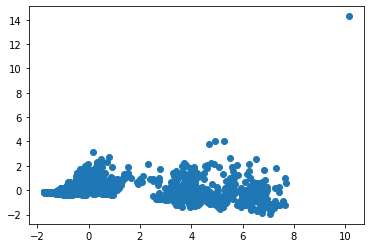

In [3]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components = 2)
X_trans = pca.fit_transform(X_stand)
plt.scatter(X_trans[:,0], X_trans[:,1])
plt.show()

In [4]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score

n = len(X)
labels = range(0, n)
scores = []
for i in np.arange(0.05, 1, 0.05):
  model = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=i)
  model.fit(X, labels)
  labels = model.apply(X)
  sil = silhouette_score(X_stand, labels)
  scores.append({'param': round(i,2), 'score': round(sil, 4)})

scores[:5]


[{'param': 0.05, 'score': 0.0859},
 {'param': 0.1, 'score': 0.1997},
 {'param': 0.15, 'score': 0.2381},
 {'param': 0.2, 'score': 0.2381},
 {'param': 0.25, 'score': 0.3049}]

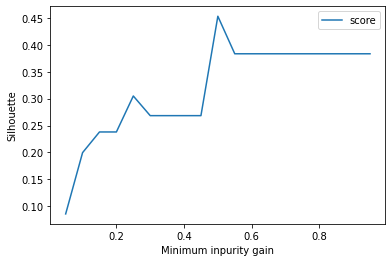

In [5]:
from matplotlib import pyplot as plt

param_list = [x['param'] for x in scores]
score_list = [x['score'] for x in scores]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Silhouette')
ax.set_xlabel('Minimum inpurity gain')
plt.plot(param_list, score_list, label = 'score')
ax.legend()
plt.show()

In [6]:
scores[0]['diff'] = 0
for i, score in enumerate(scores):
  if i == 0:
    continue
  score['diff'] = score['score'] - scores[i-1]['score']
scores[:5]

[{'param': 0.05, 'score': 0.0859, 'diff': 0},
 {'param': 0.1, 'score': 0.1997, 'diff': 0.11379999999999998},
 {'param': 0.15, 'score': 0.2381, 'diff': 0.03840000000000002},
 {'param': 0.2, 'score': 0.2381, 'diff': 0.0},
 {'param': 0.25, 'score': 0.3049, 'diff': 0.0668}]

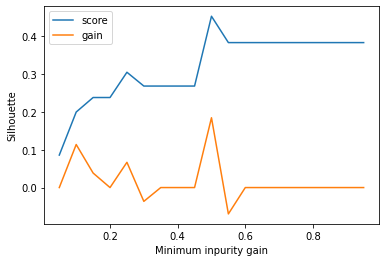

In [7]:
from matplotlib import pyplot as plt

param_list = [x['param'] for x in scores]
score_list = [x['score'] for x in scores]
diff_list = [x['diff'] for x in scores]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Silhouette')
ax.set_xlabel('Minimum inpurity gain')
plt.plot(param_list, score_list, label = 'score')
plt.plot(param_list, diff_list, label = 'gain')
ax.legend()
plt.show()

In [8]:
scores_sorted = sorted(scores, key = lambda x: x['diff'], reverse = True)
threshold = scores_sorted[0]['param']

labels = range(0, n)
model = DecisionTreeClassifier(criterion = 'entropy', min_impurity_decrease=threshold)

model.fit(X, labels)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.5)

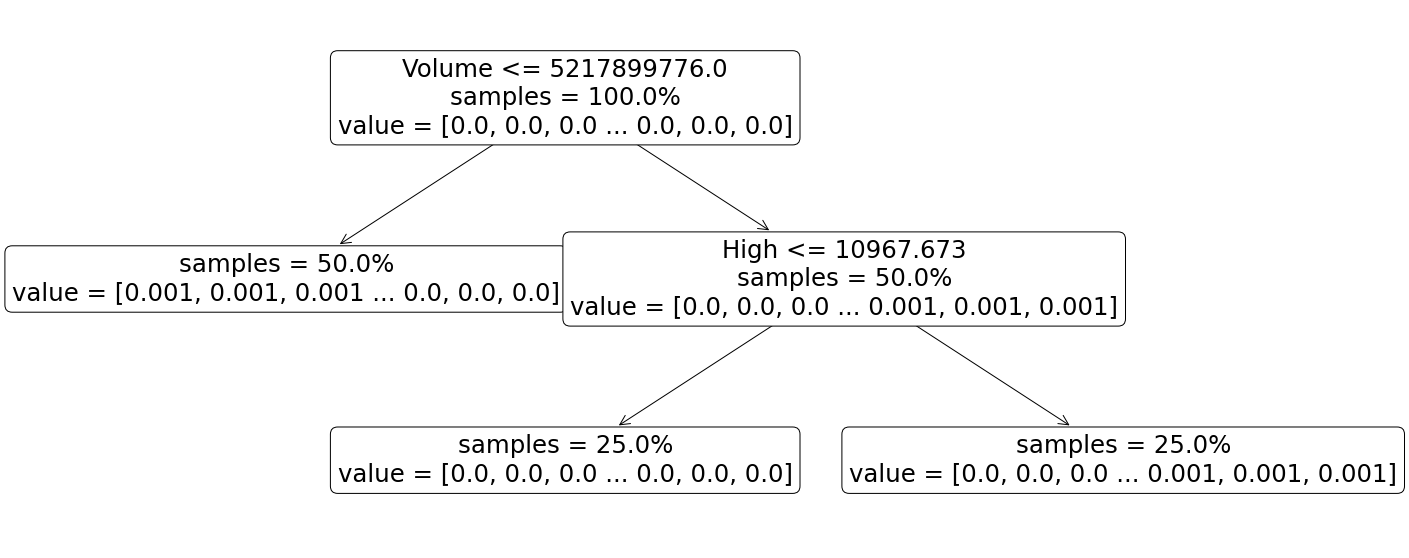

In [9]:
from sklearn import tree
import matplotlib

fig = plt.figure(figsize = (25, 10))
tree.plot_tree(model, feature_names = X.columns, impurity = False, proportion = True, rounded = True)
plt.show()

In [10]:
n_nodes = model.tree_.node_count
children_left = model.tree_.children_left
children_right = model.tree_.children_right
features = model.tree_.feature
thresholds = model.tree_.threshold

def make_node(i):
  node = {}
  node['parentID'] = i
  node['feature'] = X.columns[features[i]]
  node['threshold'] = round(thresholds[i], 2)
  return node

nodes = []
for i in range(0, n_nodes):
  if children_left[i] != -1:
    node = make_node(i)
    node['ID'] = children_left[i]
    node['comparsion'] = '<='
    nodes.append(node)
  if children_right[i] != -1:
    node = make_node(i)
    node['ID'] = children_right[i]
    node['comparsion'] = '>'
    nodes.append(node)
nodes[:5]

[{'parentID': 0,
  'feature': 'Volume',
  'threshold': 5217899776.0,
  'ID': 1,
  'comparsion': '<='},
 {'parentID': 0,
  'feature': 'Volume',
  'threshold': 5217899776.0,
  'ID': 2,
  'comparsion': '>'},
 {'parentID': 2,
  'feature': 'High',
  'threshold': 10967.67,
  'ID': 3,
  'comparsion': '<='},
 {'parentID': 2,
  'feature': 'High',
  'threshold': 10967.67,
  'ID': 4,
  'comparsion': '>'}]

In [11]:
!pip install owlready2
from owlready2 import *
import types

onto = get_ontology('onto.owl')
with onto:
  for feature in X.columns:
    onto_feature = types.new_class(feature, (DataProperty,))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.4 MB 5.1 MB/s 
  Created wheel for owlready2: filename=Owlready2-0.38-cp37-cp37m-linux_x86_64.whl size=22127083 sha256=9ece807b0ad0cafc906751069a2c8e263fe9856f7864491d43b4c420cadbd5f9
  Stored in directory: /root/.cache/pip/wheels/ee/48/58/3ea20d69efcb97a26048fbfcce9332412077df80d4ae52365b
Successfully built owlready2


In [12]:
with onto:
  for node in nodes:
    parent = node['parentID']
    if parent == 0:
      onto_parent = Thing
    else:
      onto_parent = onto[f'Class_{parent}']
    onto_class = types.new_class(f'Class_{node["ID"]}', (onto_parent,))

    onto_feature = onto[node['feature']]
    threshold = node['threshold']
    if node['comparsion'] == '<=':
      onto_class.equivalent_to.append(onto_feature.some(ConstrainedDatatype(float, max_inclusive = threshold)))
    else:
      onto_class.equivalent_to.append(onto_feature.some(ConstrainedDatatype(float, min_exclusive = threshold)))
  
onto.save('onto.owl', format = 'ntriples')

In [13]:
i = 0

with onto:
  row = X.iloc[i]
  inst = Thing(f'inst{i}')
  for feature in X.columns:
    onto_feature = onto[feature]
    onto_feature[inst].append(round(float(row[feature]), 2))

In [14]:
with onto:
  sync_reasoner_pellet()
  print(inst.is_a)
onto.save('onto_classified.owl', format = 'ntriples')

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp /usr/local/lib/python3.7/dist-packages/owlready2/pellet/slf4j-api-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jcl-over-slf4j-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/antlr-3.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/aterm-java-1.6.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/xercesImpl-2.10.0.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/antlr-runtime-3.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/slf4j-log4j12-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/commons-codec-1.6.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/httpcore-4.2.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-iri-0.9.5.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-core-2.10.0.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/httpclient-4.2.3.jar:/usr/local/lib/python3.7/

[onto.Class_3, onto.Class_1]


* Owlready2 * Pellet took 2.4179444313049316 seconds
* Owlready * Reparenting onto.inst0: {owl.Thing} => {onto.Class_3, onto.Class_1}
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)
